In [1]:
# a small tutorial on how to use the main class of the repo "PathShadowing"
# this is done on very bad generated data ("gaussian") so don't trust the results
# use this code with your own data (both generated and observed)
import os 
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from scatspectra import PriceData, MRWGenerator, TimeSeriesDataset
from shadowing import Softmax, compute_smile, PathShadowing, FovealFixed, RelativeMSE
from shadowing.utils import windows, get_smallest
    
CACHE_PATH = Path(os.getcwd()) / '_cache'  # replace with your own cache path

# 1. Generated Dataset

The generated data to look for close time-series ("shadowing" paths).

You should come up with your own generated market data (log-prices). 

Here we generate data from a multifractal random walk (MRW) for simplicity,

of course, one should perform path shadowing in a more accurate model e.g. Scattering Spectra model. 

Model MRW: using cache directory MRW_B64_T4096_L4096_H5_0e_01_la2_0e_01.


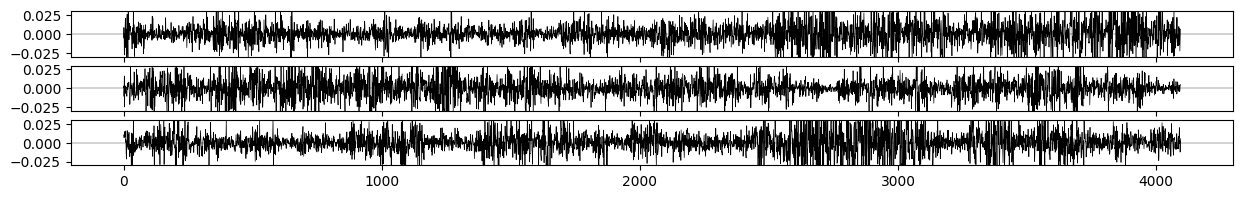

In [3]:
# create synthetic dataset
R = 8192

mrw_gen = MRWGenerator(T=4096, H=0.5, lam=0.2, cache_path=CACHE_PATH)
lnx = mrw_gen.load(R=R)
dlnx = np.diff(lnx, axis=-1)

fig, axes = plt.subplots(3, 1, figsize=(15,2))
for i, ax in enumerate(axes):
    ax.plot(dlnx[i,0,:], color='black', linewidth=0.5)
    ax.axhline(0.0, color='black', linewidth=0.25)
    ax.set_ylim(-0.03,0.03)

Model MRW: using cache directory MRW_B64_T505_L505_H5_0e_01_la2_0e_01_ob1.


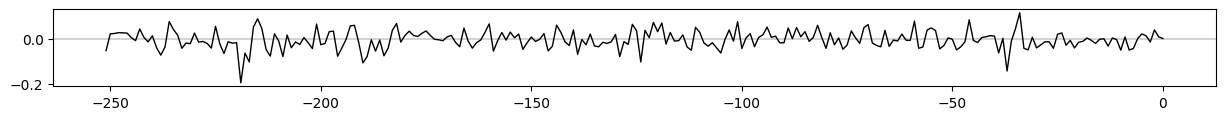

In [6]:
# observed data e.g. past time-series at different dates
# replace with the data you want to predict the future of
lnx_past = MRWGenerator(T=252*2+1, H=0.5, lam=0.2, observed=True, cache_path=CACHE_PATH).load(R=1)[0,0,:]
dlnx_past = np.diff(lnx_past, axis=-1)
dlnx_past = windows(dlnx_past, w=252, s=32)

plt.figure(figsize=(15,1))
plt.plot(np.arange(-252+1,1), dlnx_past[1,:], color='black', linewidth=1.0)
plt.axhline(0.0, color='black', linewidth=0.25);

# 2. Path Shadowing

Given observed log-returns gather the closest paths from the generated dataset.

In [7]:
S = 4096  # number of paths in the dataset that will be used for path shadowing

# the MRW dataset generated above
mrw_dataset = TimeSeriesDataset(mrw_gen.dpath, R=R, load=False)

# object for path shadowing
shadower = PathShadowing(dlnx_past=dlnx_past, 
                         dataset=mrw_dataset, 
                         S=S,
                         cache_path=CACHE_PATH,
                         dirname="shadowing_test",
                         n_splits=4,
                         verbose=True)

# embedding to reducing dimensionality
embedding = FovealFixed(alpha=1.15,  # cover the past at exponential speed 
                        beta=0.9,  # look with a weight power-law decay of 0.9
                        cut=126  # look at half-year in the observed past
                        )

# distance between reduced paths
distance = RelativeMSE()

# PERFORM PATH SHADOWING
distances, close_paths = shadower.shadow(embedding, distance, 
                                         n_paths=8192,  # the number of closest paths (from generated dataset) to retain 
                                         horizon=252,  # the size of such paths in the future
                                         num_workers=6)

Global cache path. /mnt/home/rmorel/codes/shadowing/_cache/path_shadowing/shadowing_test_640964096501201
Loading cache ...


Prediction date: 100%|██████████| 8/8 [00:00<00:00, 48.16it/s]


DONE.


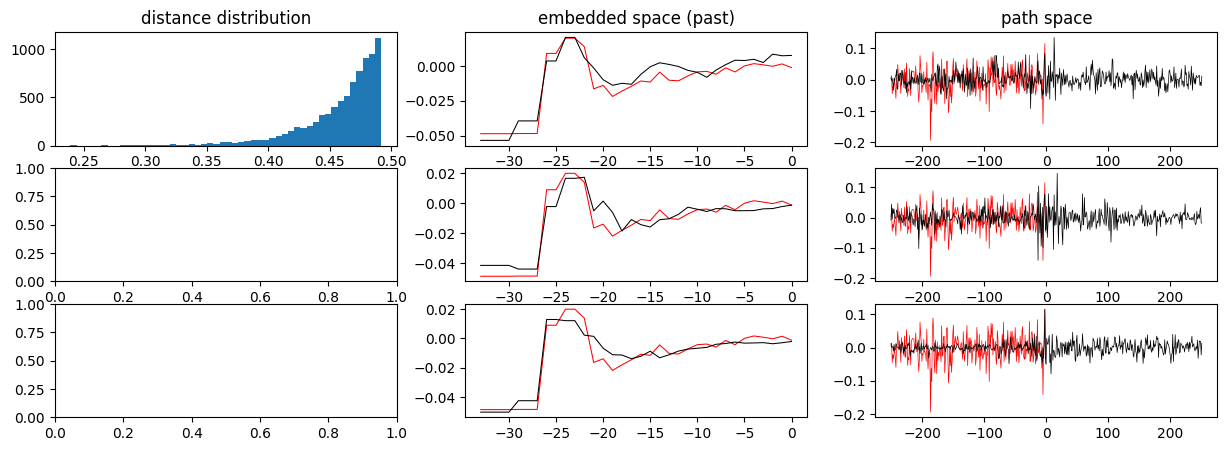

In [8]:
# some vizualization
i_date = 0

w_past = dlnx_past.shape[-1]
w_embed_past = embedding.dim
horizon = 252

# get 3 closest paths at this date
idces, ds = get_smallest(distances[i_date], 3)
dlnx_closest = np.stack([close_paths[i_date][i_path] for i_path in idces])

# embed them
dlnx_past_emb = embedding(dlnx_past[:,:w_past])
dlnx_closest_emb = embedding(dlnx_closest[:,:w_past])

fig, axes = plt.subplots(3, 3, figsize=(15, 5))
axes[0,0].set_title('distance distribution')
axes[0,0].hist(distances[i_date], bins=50)
axes[0,1].set_title('embedded space (past)')
for i, ax in enumerate(axes[:,1]):
    ts_past = np.arange(-w_embed_past+1, 1)
    ax.plot(ts_past, dlnx_past_emb[i_date,:w_embed_past], color='red', linewidth=0.75)
    ax.plot(ts_past, dlnx_closest_emb[i,:w_embed_past], color='black', linewidth=0.75)
axes[0,2].set_title('path space')
for i, ax in enumerate(axes[:,2]):
    ts_past = np.arange(-w_past+1,1)
    ts = np.arange(-w_past+1,horizon+1)
    ax.plot(ts_past, dlnx_past[i_date,:], color='red', linewidth=0.5)
    ax.plot(ts, dlnx_closest[i,:], color='black', linewidth=0.5)


# Option Pricing

Shows how to perform option pricing in two contexts


In [9]:
Ts = np.array([7,25,75])  # maturities in days
Ms = np.linspace(-2.0,2.0,9)  # rescaled log-moneyness
r = 0.00  # interest rate

### Smile at a given date

CHECK!


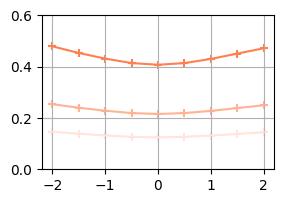

In [13]:
i_date = 0

# averaging operator in Hedged HMC
ave = Softmax(distances[i_date], eta=0.075)

# the shadowing paths extending the currently observed past
x = PriceData(dlnx=close_paths[i_date][:,w_past:], x_init=100.0).x
print("CHECK!")

# HMC on such shadowing paths
smile_conditional = compute_smile(x, Ts, Ms, r, ave)

# plotting
_, ax = plt.subplots(1, 1, figsize=(3,2))
smile_conditional.plot(ax=ax, color='coral', rescale=True)
ax.set_ylim(0.0,0.6);

### Average Smile

Model MRW: using cache directory MRW_B64_T4096_L4096_H5_0e_01_la2_0e_01.


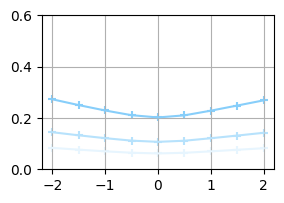

In [12]:
# snippets of MRW price trajectories
lnx_mrw = mrw_gen.load(R=1)[0,0,:]
lnx_mrw_snippets = windows(lnx_mrw, w=252, s=1)
x = PriceData(lnx=lnx_mrw_snippets, x_init=100.0).x

# HMC on such snippets
smile_avg = compute_smile(x, Ts, Ms, r, ave=None)

# plotting
_, ax = plt.subplots(1, 1, figsize=(3,2))
smile_avg.plot(ax=ax, color='lightskyblue', rescale=True)
ax.set_ylim(0.0,0.6);